In [1]:
# import required packages

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pickle
from sklearn.model_selection import train_test_split
from ml_utils.models import S2S
from ml_utils.tools import split_cycles, new_mape

In [2]:
# please make sure the TDS file "Degradation_Prediction_Dataset_ISEA.mat" is in the "data" folder
# load the original TDS file data

mat = scipy.io.loadmat('data/Degradation_Prediction_Dataset_ISEA.mat')
data0 = mat['TDS'][0]

with open('data/baumhofer_ir_interpolated.pkl','rb') as f:
    ir_interpolated = pickle.load(f)

In [3]:
# format the trajectory data once for every cell and store in a list
# then the full trajectory data is sampled at every 5 cycles in accordance to the paper

full_capa_traj = []
for r in range(113, 10782, 227):
    full_capa_traj.append(np.concatenate((data0[r][3], data0[r][5]), axis=None))   
full_ir_traj=[]
for ind, val in enumerate(ir_interpolated.keys()):
    full_ir_traj.append(ir_interpolated[val]['IR'][:,1][::5])

In [4]:
# split the trajectory data into known cycles and the rest which are to be predicted
# specify there are 47 cells in total and 100 known cycles 

X_capa, y_capa = split_cycles(47, 100, full_capa_traj)
X_ir, y_ir = split_cycles(47, 100, full_ir_traj)

In [5]:
# split the date into training and testing sets

X_capa_train, X_capa_test, y_capa_train, y_capa_test = train_test_split(X_capa, y_capa, test_size=0.2, random_state=42)
X_ir_train, X_ir_test, y_ir_train, y_ir_test = train_test_split(X_ir, y_ir, test_size=0.2, random_state=42)

In [6]:
# generate and compile the model 

m = S2S(X_capa.shape[1], y_capa.shape[1], 100)
m.compile(optimizer='Adam', loss='mae')

In [ ]:
# train the model seperately for capacity and IR trajectory predictions, make predictions and compute MAPE

m_capa_history = m.fit(X_capa_train, y_capa_train, batch_size=30, epochs=100, validation_split=0.2)
y_capa_train_Predicted = m.predict(X_capa_train)
y_capa_test_predicted = m.predict(X_capa_test)
capa_train_mape = new_mape(y_capa_train, y_capa_train_Predicted)
capa_test_mape = new_mape(y_capa_test, y_capa_test_predicted)

m_ir_history = m.fit(X_ir_train, y_ir_train, batch_size=30, epochs=100, validation_split=0.2)
y_ir_train_Predicted = m.predict(X_ir_train)
y_ir_test_predicted = m.predict(X_ir_test)
ir_train_mape = new_mape(y_ir_train, y_ir_train_Predicted)
ir_test_mape = new_mape(y_ir_test, y_ir_test_predicted)

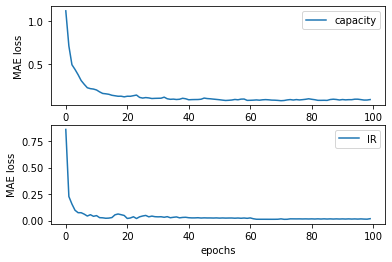

In [8]:
# plot the training results

fig, ax = plt.subplots(2, 1)
ax[0].plot(m_capa_history.history['loss'])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('MAE loss')
ax[0].legend(['capacity'])
ax[1].plot(m_ir_history.history['loss'])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('MAE loss')
ax[1].legend(['IR'])

In [9]:
# print the MAPE results

print('Training MAPE for capacity: ', capa_train_mape)
print('Testing MAPE for capacity: ', capa_test_mape)
print('Training MAPE for IR: ', ir_train_mape)
print('Testing MAPE for IR: ', ir_test_mape)

Training MAPE for capacity:  6.592349541454044
Testing MAPE for capacity:  7.382196326031205
Training MAPE for IR:  60.59089914832746
Testing MAPE for IR:  60.6174880925726
